# Introduction
---
In this project we'll be working with a telecommunications company, <em>Interconnect</em>, build a machine learning prototype model to help identify customers that are at risk of terminating their service. This model would aim to reduce customer churn effectively. 

The model will be evaluated and scored using accuracy, f1, and roc-auc scoring metrics, with roc-auc score being oiur primary metric.

---
## Data Overview
---

In [15]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Loading datasets
personal_df = pd.read_csv('~/Documents//final_provider/personal.csv')
contract_df = pd.read_csv('~/Documents/final_provider/contract.csv')
phone_df = pd.read_csv('~/Documents/final_provider/phone.csv')
internet_df = pd.read_csv('~/Documents/final_provider/internet.csv')

In [17]:
print(personal_df.info())
print(contract_df.info())
print(phone_df.info())
print(internet_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   To

We see that half of the datasets are missing observations so we expect to see missing values when combininbg the tables.

The columns with datetime values must be changed. The current dates should be determined and filled into the `end_date` column so we can engineer a `service_length` column detailing how long each customer has been with the company, including current customers as we may find a trend there. 

`total_charges` dtype must be changes to float as well to facilitate proper analysis.

In [18]:
print(personal_df.duplicated().sum())
print(contract_df.duplicated().sum())
print(phone_df.duplicated().sum())
print(internet_df.duplicated().sum())

0
0
0
0


No duplicates found

In [19]:
print(personal_df.isna().sum())
print(contract_df.isna().sum())
print(phone_df.isna().sum())
print(internet_df.isna().sum())

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
customerID       0
MultipleLines    0
dtype: int64
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


no conventional missing data values found prior to merging. Let's check for any unconventional missing placeholder values after merging for convenience.

In [20]:
df_all = personal_df.merge(contract_df,on='customerID',how='outer')
df_all = df_all.merge(phone_df,on='customerID',how='outer')
df_all = df_all.merge(internet_df,on='customerID',how='outer')
df_all.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0002-ORFBO,Female,0,Yes,Yes,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,No,DSL,No,Yes,No,Yes,Yes,No
1,0003-MKNFE,Male,0,No,No,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,Yes,DSL,No,No,No,No,No,Yes
2,0004-TLHLJ,Male,0,No,No,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,No,Fiber optic,No,No,Yes,No,No,No


Column names must be changed to standard format. Yes/No values must be changed to 0/1 and other categorical features must be encoded for future model training. 

Let's observe the columns and check for any value relationship at an attempt to find a relationship between values. Being that the `end_date` is ultimately our target valuesbut has a mix of dates and string values, we'll feature engineer a new column with 0/1 values to indicate churned customers. We'll name it `terminated` after we adjust column names

In [21]:
df_all = df_all.rename(columns={
    'customerID' : 'customer_id',
    'SeniorCitizen' : 'senior_citizen',
    'Partner' : 'partner',
    'Dependents' : 'dependents',
    'BeginDate' : 'begin_date',
    'EndDate' : 'end_date',
    'Type' : 'type',
    'PaperlessBilling' : 'paperless_billing',
    'PaymentMethod' : 'payment_method',
    'MonthlyCharges' : 'monthly_charges',
    'TotalCharges' : 'total_charges',
    'MultipleLines' : 'multiple_lines',
    'InternetService' : 'internet_service',
    'OnlineSecurity' : 'online_security',
    'OnlineService' : 'online_security',
    'OnlineBackup' : 'online_backup',
    'DeviceProtection' : 'device_protection',
    'TechSupport' : 'tech_support',
    'StreamingTV' : 'streaming_tv',
    'StreamingMovies' : 'streaming_movies'
})
df_all.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [22]:
# Creating target column 
df_all['terminated'] = [1 if x != 'No' else 0 for x in df_all['end_date']]
df_all['terminated'].head(3)

0    0
1    0
2    1
Name: terminated, dtype: int64

In [23]:
df_all.isna().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
multiple_lines        682
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
terminated              0
dtype: int64

Many missing values. We'll determine how to handle these missing values after asking a few clarifying questions in our next steps.

Let's search for any unconventional missing values.

In [24]:
df_all['gender'].value_counts(dropna=False)

gender
Male      3555
Female    3488
Name: count, dtype: int64

No missing gender values. Can see close to an even gender distribution.

In [25]:
df_all['senior_citizen'].value_counts(dropna=False)

senior_citizen
0    5901
1    1142
Name: count, dtype: int64

Almost 1/6 of total customers are not senior citizens. This is fine being that this is not our target feature. Let's see how senior citizen customer retention looks with a simple bar plot

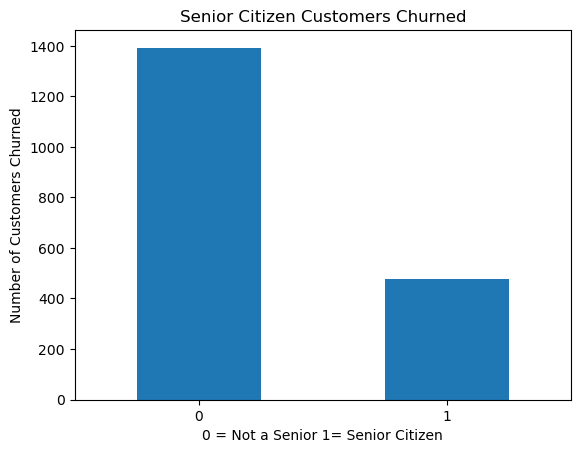

In [26]:
df_all.groupby('senior_citizen')['terminated'].sum().plot(kind='bar',rot=1)
plt.title('Senior Citizen Customers Churned')
plt.xlabel('0 = Not a Senior 1= Senior Citizen')
plt.ylabel('Number of Customers Churned')
plt.show()

In [27]:
print('Out of 1142 senior customers,',df_all[(df_all['senior_citizen'] == 1) & (df_all['terminated'] == 1)].count()[1]/df_all['senior_citizen'].sum(),'% terminated their\ncontract. Seniors may not be too internet saavvy and ')

Out of 1142 senior customers, 0.4168126094570928 % terminated their
contract. Seniors may not be too internet saavvy and 


/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_11521/939636649.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Out of 1142 senior customers,',df_all[(df_all['senior_citizen'] == 1) & (df_all['terminated'] == 1)].count()[1]/df_all['senior_citizen'].sum(),'% terminated their\ncontract. Seniors may not be too internet saavvy and ')


In [28]:
df_all['partner'].value_counts()

partner
No     3641
Yes    3402
Name: count, dtype: int64

In [29]:
df_all['dependents'].value_counts()

dependents
No     4933
Yes    2110
Name: count, dtype: int64

In [30]:
df_all['begin_date'].value_counts(dropna=False)

begin_date
2014-02-01    366
2019-09-01    237
2019-11-01    237
2019-10-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: count, Length: 77, dtype: int64

In [31]:
df_all['end_date'].value_counts()

end_date
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

Interesting to see all termination dates within a 4 month timespan. What happened between 2019-20-01 to 2020-01-01? Service interruptions? Billing errors? Technical difficulties? Or could it have been an error in the recording of the data?

In [32]:
df_all['type'].value_counts(dropna=False)

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [33]:
df_all['paperless_billing'].value_counts()

paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64

In [34]:
df_all['payment_method'].value_counts()

payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

Let's find if the payment method could have had any effect on number of `terminated` customers

<Axes: xlabel='payment_method'>

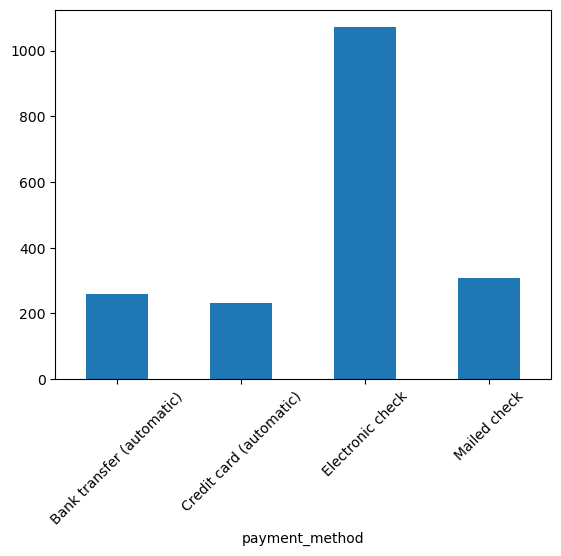

In [35]:
df_all.groupby('payment_method')['terminated'].sum().plot(kind='bar',rot=45)

E-checks have an abnormal imbalance in resulting customer's whom terminated their service. The customers whom have made payments using e-checks account for almost 60% of total customers churned.

Seems there could be an underlying issue there. Processing delays or errors? Let's check the `end_date` of those customers service to have some insight on what the matter could be.

In [36]:
df_all[(df_all['payment_method'] == 'Electronic check')&(df_all['terminated'] == 1)]['end_date'].value_counts()

end_date
2020-01-01 00:00:00    280
2019-11-01 00:00:00    265
2019-12-01 00:00:00    265
2019-10-01 00:00:00    261
Name: count, dtype: int64

Seems there could be some techincal/processing issues there being that the `end_dates` are all in a 4 month period.

In [37]:
df_all['monthly_charges'].value_counts()

monthly_charges
20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
116.55     1
106.85     1
68.55      1
108.80     1
67.85      1
Name: count, Length: 1585, dtype: int64

In [38]:
df_all['total_charges'].value_counts()

total_charges
           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
2387.75     1
6302.8      1
2058.5      1
829.55      1
3707.6      1
Name: count, Length: 6531, dtype: int64

We have 11 missing values within the `total_charges` column. We can fill in those values by multiplying their `monthly_charges` values by their length of service.

Let's see if those observations are also missing values in other columns

In [39]:
df_all[df_all['total_charges'] == ' ']['monthly_charges']

945     56.05
1731    20.00
1906    61.90
2025    19.70
2176    20.25
2250    25.35
2855    73.35
3052    25.75
3118    52.55
4054    80.85
5433    19.85
Name: monthly_charges, dtype: float64

Great, this will be an easy fix. We'll move on

In [40]:
df_all['multiple_lines'].value_counts()

multiple_lines
No     3390
Yes    2971
Name: count, dtype: int64

We know the above has missing values but now can confirm no unconventional missing value placeholders which also applies to the following, remaining columns.

In [41]:
df_all['internet_service'].value_counts()

internet_service
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

In [42]:
df_all['online_security'].value_counts()

online_security
No     3498
Yes    2019
Name: count, dtype: int64

In [43]:
df_all['online_backup'].value_counts()

online_backup
No     3088
Yes    2429
Name: count, dtype: int64

In [44]:
df_all['device_protection'].value_counts()

device_protection
No     3095
Yes    2422
Name: count, dtype: int64

In [45]:
df_all['tech_support'].value_counts()

tech_support
No     3473
Yes    2044
Name: count, dtype: int64

In [46]:
df_all['streaming_tv'].value_counts()

streaming_tv
No     2810
Yes    2707
Name: count, dtype: int64

In [47]:
df_all['streaming_movies'].value_counts()

streaming_movies
No     2785
Yes    2732
Name: count, dtype: int64

The final columns seem to be without any unconventional placeholders for missing values. We'll still have to fill in the `NaN` values.

For now we'll move on and check for class imbalance.

In [48]:
df_all['terminated'].value_counts()

terminated
0    5174
1    1869
Name: count, dtype: int64

There is a significant class imbalance.

# Work Plan
- We'll fill in the missing values as accurately as possible.
- We'll fill in any missing values  in the `total_charges` column by multiplying the monthly charges by length of service
- create columns with length of service in months. observations with no end date will just be dated as one month after latest `begin_date` or `end_date` (whichever has later date) as we'll assume this dataset is a from the previous month looking into future months.
- change categorical columns to categorical dtypes
- We must also remove outliers as well by eliminating the observations over 3 standard deviations from the mean

- Use OneHotEncoding to encode the categorical features

-  We'll utilize the SMOTE method to upsample our minority classes and create class balance for proer model training

- We'll normalize our continuous features using the sklearn StandardScaler tool
- Training, validation, and test sets will be created for propert model evaluation
- We'll create 3 models and visualize its performance (XGBoost, CatBoost, and a thrid to be determined depending on the previous model's performance)
- The best performing model will be selected for final testing

__Clarifying questions__:
- Is there a price guide? i.e price per line (to determine missing values in `multiple_lines`), price for `online_security`, `online_backup`, etc to accurately formulate a way to fill in any missing values
- Does the feature have to be `end_date` or am I allowed to feature engineer a new feature as done with the `terminated` feature in this notebook?
